In [1]:
!pip3 show gensim

Name: gensim
Version: 3.6.0
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPLv2.1
Location: /home/fox/.local/lib/python3.10/site-packages
Requires: numpy, scipy, six, smart-open
Required-by: 


In [2]:
from gensim.models import Word2Vec
from datetime import datetime
import os
import wget
import numpy as np
from collections import defaultdict
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from gensim.models import FastText
import gzip
from ipynb.fs.defs.functions_and_classes import Dataset, Datapoint
from ipynb.fs.defs.functions_and_classes import build_dict_from_vector_file, display_embedding_properties, load_dataset_from_csv

In [3]:
#model = 'word2vec'
model = 'glove'
#model = 'fasttext'
dim = 100
language = 'he'

# Loading

In [4]:
def build_dict_from_model(model, vocab):
    """ For processing Word2Vec .model files. The .npy files are also needed. Works with gensim 3.6"""
    embedding = defaultdict()
    for word in list(vocab):
        embedding[word] = model[word]
    display_embedding_properties(embedding)
    return embedding

In [5]:
def build_dict_from_vector_file(path_to_vecs, filename):
    """ For processing GloVe .txt models. Might no longer be needed for newer versions of gensim,
    as the gensim load_word2vec_format function can handle GloVe outputs as well"""
    embedding = {}
    if filename not in os.listdir(path_to_vecs):
        print(f'File not found. Generate it using GloVe.')
    with open(path_to_vecs+filename, 'r') as f:
        f = f.read().split('\n')
        f = [l.split(' ') for l in f]
        n_entries = len(f)
        for i, l in enumerate(f):
            w = l[0]
            try:
                v = np.array([float(x) for x in l[1:]])
            except ValueError:
                print(f'Line: {i}')
                print(f'Word: {w}')
                print(f'Vector: {l[1:]}')
            embedding[w] = v
            if (i % 50000 == 0):
                print(f'Processed {i} / {n_entries} entries')
    display_embedding_properties(embedding)
    return embedding

In [6]:
if model == 'word2vec':
    inp = f'word2vec_{dim}_{language}.model'
    print(f'Loading started {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
    m = Word2Vec.load(f'./models/raws/{inp}')
    print(f'Loading ended {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
    embedding = build_dict_from_model(m.wv, m.wv.vocab.keys())
if model == 'glove':
    inp = f'glove_{dim}_{language}_vectors.txt'
    print(f'Loading started {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
    embedding = build_dict_from_vector_file('./models/raws/', inp)
    print(f'Loading ended {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
if model == 'fasttext':
    if 'cc.he.300.bin' not in os.listdir('./models/raws/'):
        # We'll have to regenerate the model
        if 'cc.he.300.bin.gz' not in os.listdir('./models/raws/'):
        # We'll have to re-download the model
            URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.he.300.bin.gz'
            response = wget.download(URL, './models/raws/cc.he.300.bin.gz')

            # Extracting the archive
            with gzip.open('cc.he.300.bin.gz', 'rb') as f_in:
                with open('cc.he.300.bin', 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            #!gzip -d cc.he.300.bin.gz

        # Trick from https://vasnetsov93.medium.com/
        #shrinking-fasttext-embeddings-so-that-it-fits-google-colab-cd59ab75959e
    print(f'Loading started {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
    m = FastText.load_fasttext_format('./models/raws/cc.he.300.bin')
    print(f'Loading ended {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

    # we are not saving trainables here
    m.wv.save(f'./models/raws/fasttext_{dim}_{language}.model')
    print(f'Saving ended {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

    pretrained_embedding = build_dict_from_model(m.wv, m.wv.vocab.keys())

Loading started 2022-10-02 15:30:17
Processed 0 / 584162 entries
Processed 50000 / 584162 entries
Processed 100000 / 584162 entries
Processed 150000 / 584162 entries
Processed 200000 / 584162 entries
Processed 250000 / 584162 entries
Processed 300000 / 584162 entries
Processed 350000 / 584162 entries
Processed 400000 / 584162 entries
Processed 450000 / 584162 entries
Processed 500000 / 584162 entries
Processed 550000 / 584162 entries
Embedding entries: 584162
Embedding dimension: 100
Loading ended 2022-10-02 15:30:45


# Dataset adjustment

In [7]:
"""dataset = [{'noun':'מחשב', 'denom':['למחשב',''], 'non_denom':['לחשב','להתחשב'], 'others':['לחשוב','להחשיב','להיחשב'], 'ambig_inflected':True, 'ambig_uninflected':True, 'ambig_with':'לחשב'},
           {'noun':'תחזוקה', 'denom':['לתחזק',''], 'non_denom':['לחזק','להתחזק'], 'others':['','להחזיק',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'מחזור', 'denom':['למחזר',''], 'non_denom':['לחזר','להתחזר'], 'others':['לחזור','להחזיר',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'חשבון', 'denom':['','להתחשבן'], 'non_denom':['לחשב','להתחשב'], 'others':['לחשוב','להחשיב','להיחשב'], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'תקשורת', 'denom':['לתקשר',''], 'non_denom':['לקשר','להתקשר'], 'others':['לקשור','','להיקשר'], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'תפקידים', 'denom':['לתפקד',''], 'non_denom':['לפקד','להתפקד'], 'others':['לפקוד','להפקיד','להיפקד'], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'להפקיד'},
           {'noun':'תרגילים', 'denom':['לתרגל',''], 'non_denom':['לרגל','להתרגל'], 'others':['','להרגיל',''], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'להרגיל'},
           {'noun':'פלצן', 'denom':['','להתפלצן'], 'non_denom':['','להתפלץ'], 'others':['','להפליץ',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'תזמורת', 'denom':['לתזמר',''], 'non_denom':['לזמר',''], 'others':['','',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'תזמון', 'denom':['לתזמן',''], 'non_denom':['לזמן','להזדמן'], 'others':['','להזמין',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'סקרנים', 'denom':['לסקרן','להסתקרן'], 'non_denom':['לסקר',''], 'others':['לסקור','','להיסקר'], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'לסקרן'},
           {'noun':'תקציר', 'denom':['לתקצר',''], 'non_denom':['לקצר',''], 'others':['לקצור','להתקצר','להיקצר'], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'מלכודת', 'denom':['למלכד',''], 'non_denom':['ללכד','להתלכד'], 'others':['ללכוד','','להילכד'], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'אבטחה', 'denom':['לאבטח',''], 'non_denom':['לבטח',''], 'others':['לבטוח','להבטיח',''], 'ambig_inflected':True, 'ambig_uninflected':True, 'ambig_with':'לאבטח'},
           {'noun':'קמצן', 'denom':['','להתקמצן'], 'non_denom':['לקמץ',''], 'others':['','',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'שלהבת', 'denom':['לשלהב','להשתלהב'], 'non_denom':['','להתלהב'], 'others':['','להלהיב',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'עצבני', 'denom':['לעצבן','להתעצבן'], 'non_denom':['לעצב','להתעצב'], 'others':['','להעציב','להיעצב'], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'מרכז', 'denom':['למרכז','להתמרכז'], 'non_denom':['לרכז','להתרכז'], 'others':['','',''], 'ambig_inflected':True, 'ambig_uninflected':True, 'ambig_with':'לרכז'},
           {'noun':'תסביך', 'denom':['לתסבך',''], 'non_denom':['לסבך','להסתבך'], 'others':['','',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'מסגרת', 'denom':['למסגר',''], 'non_denom':['','להסתגר'], 'others':['לסגור','להסגיר','להיסגר'], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'אכזבות', 'denom':['לאכזב','להתאכזב'], 'non_denom':['לכזב',''], 'others':['','להכזיב',''], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'לאכזב'},
           {'noun':'מסחר', 'denom':['','להתמסחר'], 'non_denom':['',''], 'others':['לסחור','','להיסחר'], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'תעתיקים', 'denom':['לתעתק',''], 'non_denom':['',''], 'others':['','להעתיק',''], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'להעתיק'},
           {'noun':'תדריכים', 'denom':['לתדרך',''], 'non_denom':['',''], 'others':['לדרוך','להדריך','להידרך'], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'להדריך'},
           {'noun':'תמריצים', 'denom':['לתמרץ',''], 'non_denom':['',''], 'others':['','להמריץ',''], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'להמריץ'},
           {'noun':'תקציבים', 'denom':['לתקצב',''], 'non_denom':['',''], 'others':['לקצוב','להקציב','להיקצב'], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'להקציב'},
           {'noun':'תצפית', 'denom':['לתצפת',''], 'non_denom':['',''], 'others':['לצפות','',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'אבחנות', 'denom':['לאבחן',''], 'non_denom':['',''], 'others':['לבחון','להבחין','להיבחן'], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'לאבחן'},
           {'noun':'תחקיר', 'denom':['לתחקר',''], 'non_denom':['',''], 'others':['לחקור','','להיחקר'], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'תסריטים', 'denom':['לתסרט',''], 'non_denom':['',''], 'others':['','להסריט',''], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'להסריט'},
           {'noun':'תקליטים', 'denom':['לתקלט',''], 'non_denom':['',''], 'others':['לקלוט','להקליט','להיקלט'], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'להקליט'},
           {'noun':'אזכרות', 'denom':['לאזכר',''], 'non_denom':['',''], 'others':['לזכור','להזכיר','להיזכר'], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'לאזכר'},
           {'noun':'מספר', 'denom':['למספר',''], 'non_denom':['לספר','להסתפר'], 'others':['לספור','','להיספר'], 'ambig_inflected':True, 'ambig_uninflected':True, 'ambig_with':'לספר'},
           {'noun':'טרחנים', 'denom':['לטרחן',''], 'non_denom':['',''], 'others':['לטרוח','להטריח',''], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'לטרחן'},
           {'noun':'מרפק', 'denom':['למרפק',''], 'non_denom':['','להתרפק'], 'others':['','',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'מסמר', 'denom':['למסמר',''], 'non_denom':['לסמר',''], 'others':['לסמור','',''], 'ambig_inflected':True, 'ambig_uninflected':True, 'ambig_with':'לסמר'},
           {'noun':'אזרחים', 'denom':['לאזרח','להתאזרח'], 'non_denom':['',''], 'others':['לזרוח','',''], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'לאזרח'},
           {'noun':'אגרופים', 'denom':['','להתאגרף'], 'non_denom':['',''], 'others':['לגרוף','','להיגרף'], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'לגרוף'},
           {'noun':'מסכן', 'denom':['למסכן','להתמסכן'], 'non_denom':['לסכן','להסתכן'], 'others':['','',''], 'ambig_inflected':True, 'ambig_uninflected':True, 'ambig_with':'לסכן'},
           {'noun':'תגמולים', 'denom':['לתגמל',''], 'non_denom':['','להיגמל'], 'others':['לגמול','','להיגמל'], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'לגמול'},
           {'noun':'חרבון', 'denom':['לחרבן','להתחרבן'], 'non_denom':['לחרב','להתחרב'], 'others':['','להחריב','להיחרב'], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'צלחות', 'denom':['לצלחת',''], 'non_denom':['',''], 'others':['לצלוח','להצליח',''], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'לצלוח'},
           {'noun':'משכון', 'denom':['למשכן',''], 'non_denom':['לשכן','להשתכן'], 'others':['לשכון','להשכין',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'תגבורת', 'denom':['לתגבר',''], 'non_denom':['','להתגבר'], 'others':['לגבור','להגביר',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'מסמך', 'denom':['למסמך',''], 'non_denom':['','להסתמך'], 'others':['לסמוך','להסמיך',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'תאריכים', 'denom':['לתארך',''], 'non_denom':['','להתארך'], 'others':['לארוך','להאריך',''], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'להאריך'},
           {'noun':'תכסיס', 'denom':['לתכסס',''], 'non_denom':['',''], 'others':['לכסוס','',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'מזרח', 'denom':['','להתמזרח'], 'non_denom':['',''], 'others':['לזרוח','להזריח',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'מערב', 'denom':['','להתמערב'], 'non_denom':['לערב','להתערב'], 'others':['לערוב','',''], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'לערב'},
           {'noun':'מקצוע', 'denom':['למקצע','להתמקצע'], 'non_denom':['',''], 'others':['לקצוע','',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'תזכורת', 'denom':['לתזכר',''], 'non_denom':['',''], 'others':['לזכור','להזכיר','להיזכר'], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'מגדרים', 'denom':['למגדר',''], 'non_denom':['לגדר',''], 'others':['','להגדיר',''], 'ambig_inflected':True, 'ambig_uninflected':True, 'ambig_with':'לגדר'},
           {'noun':'פרשנים', 'denom':['לפרשן','להתפרשן'], 'non_denom':['לפרש','להתפרש'], 'others':['לפרוש','להפריש',''], 'ambig_inflected':False, 'ambig_uninflected':True, 'ambig_with':'לפרשן'},
           {'noun':'קורבן', 'denom':['','להתקרבן'], 'non_denom':['','להתקרב'], 'others':['','להקריב',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},
           {'noun':'חמצן', 'denom':['לחמצן','להתחמצן'], 'non_denom':['',''], 'others':['','להחמיץ','להיחמץ'], 'ambig_inflected':True, 'ambig_uninflected':True, 'ambig_with':'לחמצן'},]"""

"dataset = [{'noun':'מחשב', 'denom':['למחשב',''], 'non_denom':['לחשב','להתחשב'], 'others':['לחשוב','להחשיב','להיחשב'], 'ambig_inflected':True, 'ambig_uninflected':True, 'ambig_with':'לחשב'},\n           {'noun':'תחזוקה', 'denom':['לתחזק',''], 'non_denom':['לחזק','להתחזק'], 'others':['','להחזיק',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},\n           {'noun':'מחזור', 'denom':['למחזר',''], 'non_denom':['לחזר','להתחזר'], 'others':['לחזור','להחזיר',''], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},\n           {'noun':'חשבון', 'denom':['','להתחשבן'], 'non_denom':['לחשב','להתחשב'], 'others':['לחשוב','להחשיב','להיחשב'], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},\n           {'noun':'תקשורת', 'denom':['לתקשר',''], 'non_denom':['לקשר','להתקשר'], 'others':['לקשור','','להיקשר'], 'ambig_inflected':False, 'ambig_uninflected':False, 'ambig_with':''},\n           {'noun':'תפקידים', 'denom':['לתפקד',''], 'non_denom':['ל

In [8]:
"""with open('./hebrew dataset/definitive_dataset.csv' ,'w') as f:
    f.write('Noun,Denominal(s),Non-denominal(s),Other(s)\n')
    for dp in dataset:
        n = dp['noun']
        dns = dp['denom']
        dns = [dn for dn in dns if dn != '']
        dns = ' '.join(dns)
        ndns = dp['non_denom']
        ndns = [ndn for ndn in ndns if ndn != '']
        ndns = ' '.join(ndns)
        others = dp['others']
        others = [other for other in others if other != '']
        others = ' '.join(others)
        print(dns)
        print(ndns)
        print(others)
        f.write(f'{n},{dns},{ndns},{others}\n')"""

"with open('./hebrew dataset/definitive_dataset.csv' ,'w') as f:\n    f.write('Noun,Denominal(s),Non-denominal(s),Other(s)\n')\n    for dp in dataset:\n        n = dp['noun']\n        dns = dp['denom']\n        dns = [dn for dn in dns if dn != '']\n        dns = ' '.join(dns)\n        ndns = dp['non_denom']\n        ndns = [ndn for ndn in ndns if ndn != '']\n        ndns = ' '.join(ndns)\n        others = dp['others']\n        others = [other for other in others if other != '']\n        others = ' '.join(others)\n        print(dns)\n        print(ndns)\n        print(others)\n        f.write(f'{n},{dns},{ndns},{others}\n')"

In [9]:
dataset = load_dataset_from_csv('./hebrew dataset/definitive_dataset.csv')

In [10]:
dataset.display_content()

Datapoint #1:
Noun: מחשב
Denominal(s): ['למחשב']
Non-denominal(s): ['לחשב', 'להתחשב']
Other(s): ['לחשוב', 'להחשיב', 'להיחשב']
Datapoint #2:
Noun: תחזוקה
Denominal(s): ['לתחזק']
Non-denominal(s): ['לחזק', 'להתחזק']
Other(s): ['להחזיק']
Datapoint #3:
Noun: מחזור
Denominal(s): ['למחזר']
Non-denominal(s): ['לחזר', 'להתחזר']
Other(s): ['לחזור', 'להחזיר']
Datapoint #4:
Noun: חשבון
Denominal(s): ['להתחשבן']
Non-denominal(s): ['לחשב', 'להתחשב']
Other(s): ['לחשוב', 'להחשיב', 'להיחשב']
Datapoint #5:
Noun: תקשורת
Denominal(s): ['לתקשר']
Non-denominal(s): ['לקשר', 'להתקשר']
Other(s): ['לקשור', 'להיקשר']
Datapoint #6:
Noun: תפקידים
Denominal(s): ['לתפקד']
Non-denominal(s): ['לפקד', 'להתפקד']
Other(s): ['לפקוד', 'להפקיד', 'להיפקד']
Datapoint #7:
Noun: תרגילים
Denominal(s): ['לתרגל']
Non-denominal(s): ['לרגל', 'להתרגל']
Other(s): ['להרגיל']
Datapoint #8:
Noun: פלצן
Denominal(s): ['להתפלצן']
Non-denominal(s): ['להתפלץ']
Other(s): ['להפליץ']
Datapoint #9:
Noun: תזמורת
Denominal(s): ['לתזמר']
Non-denomi

In [11]:
dataset.filter_against_embedding(embedding)

Number of datapoints before adjustment: 55
Number of datapoints after adjustment: 29


In [12]:
triplets = dataset.get_triplets()
lexicon = dataset.get_lexicon()
vecs = dataset.get_vecs(embedding)

# Reduction

In [13]:
"""def get_target_dim(vecs):
    cov_matrix = np.cov(vecs.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    #sort the eigenvalues in descending order
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_index]
    #similarly sort the eigenvectors 
    sorted_eigenvectors = eigenvectors[:,sorted_index]
    target_dim = len([ev for ev in eigenvalues if ev >= 1])
    eigenvector_subset = sorted_eigenvectors[:,0:target_dim]
    print(eigenvector_subset.shape)
    #vecs_reduced = np.dot(eigenvector_subset.transpose(),X_meaned.transpose()).transpose()
    print(vecs.shape)
    return target_dim, np.dot(vecs, eigenvector_subset)"""
    
def reduce_dim(words, vecs):
    pca = PCA(n_components=.9, svd_solver='full')
    """pca.fit(vecs)
    print(f'Intermediate dimension: {pca.n_components_}')
    target_dim = len([sv for sv in pca.singular_values_ if sv >=1])
    pca = PCA(n_components=target_dim)"""
    all_vecs_reduced = pca.fit_transform(vecs)
    print(f'Initial dimension: {len(vecs[0])}')
    print(f'Final dimension: {pca.n_components_}')
    print(f'Explained variance: {np.sum(pca.explained_variance_ratio_)}')
    plt.plot(pca.explained_variance_ratio_)
    plt.title('Explained variance ratio for each component of the PCA \n (sorted from most significant to least significant)')
    plt.show()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('Cumulative sum of the explained variance ratios of the PCA')
    plt.show()
    
    return dict(zip(words, all_vecs_reduced))

Initial dimension: 100
Final dimension: 47
Explained variance: 0.9010768487034527


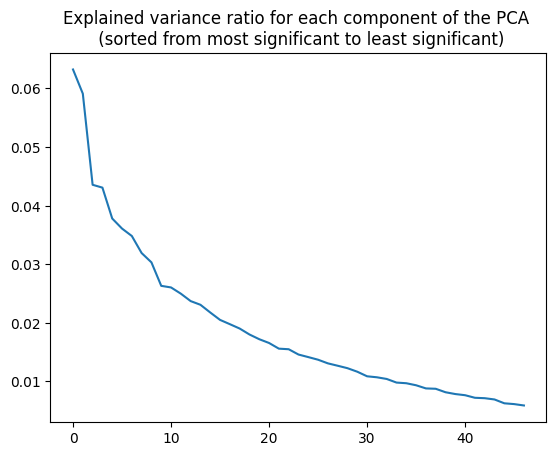

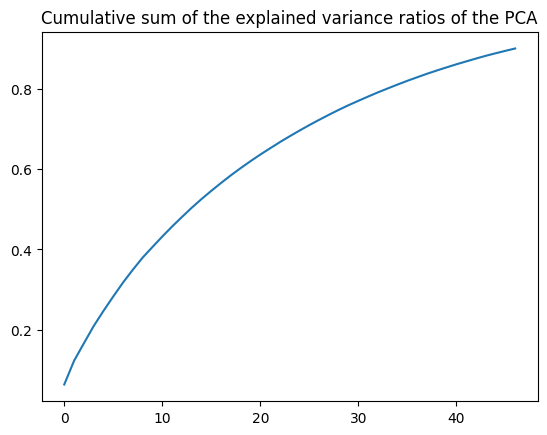

In [14]:
reduced_embedding = reduce_dim(lexicon, vecs)

# Save

In [15]:
def write_dict_to_vector_file(embedding):
    fname = f'{model}_{dim}_{language}_vectors_reduced.txt'
    with open(f'./models/reduced/{fname}', 'w') as f:
        for w, v in embedding.items():
            l = f'{w} '
            for x in v:
                l = l+f'{str(x)} '
            l = l[:-1]+'\n'
            f.write(l)

In [16]:
write_dict_to_vector_file(reduced_embedding)